## Settings

graph-tool is always a bit tricky to install because of its dependencies. Run the following lines and it should do the trick.

In [ ]:
#@title setting 1
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update &> /dev/null
!apt-get install python3-graph-tool python3-matplotlib python3-cairo &> /dev/null

In [ ]:
#@title setting 2
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo &> /dev/null
!apt install libcairo2-dev pkg-config python3-dev &> /dev/null
!pip install --force-reinstall pycairo &> /dev/null
!pip install zstandard &> /dev/null

In [ ]:
#@title import libraries

import networkx as nx
import numpy as np
import graph_tool.all as gt
from collections import Counter
import matplotlib.pyplot as plt
import json
import pandas as pd
import csv

print(f"nx: {nx.__version__}")
print(f"graph-tool: {gt.__version__}")

In [ ]:
#@title helper functions
def print_summary(name, subname=None):
  for k,v in gt.collection.ns_info[name].items():
    print(k, end="\n----------\n")
    if subname is not None and k == 'analyses':
      v = gt.collection.ns_info[name]['analyses'][subname]
      for ka, va in v.items():
        print(f"{ka}: {va}")
      continue
    if isinstance(v, dict):
      for ka, va in v.items():
        print(f"{ka}: {va}")
    else:
      print(v)
    print("\n")


def prop_to_size_custom(values, min_bound=5, max_bound=15):
    """
    Normalizes a list of floats to be within a specified range [min_bound, max_bound].

    Parameters:
    values (list of float): The list of values to be normalized.
    min_bound (float): The minimum bound of the normalized range (default is 5).
    max_bound (float): The maximum bound of the normalized range (default is 15).

    Returns:
    list of float: The list with values normalized to the specified range.
    """
    min_val = min(values)
    max_val = max(values)
    # Prevent division by zero if all values are the same
    if min_val == max_val:
        return [min_bound] * len(values)

    return [
        min_bound + (value - min_val) * (max_bound - min_bound) / (max_val - min_val)
        for value in values
    ]

## Network Visualization: [Netzschleuder](https://networks.skewed.de/)

 - see also: https://graph-tool.skewed.de/static/doc/collection.html#module-graph_tool.collection

## Small-size networks: 7th graders

In [ ]:
print_summary("7th_graders")

analyses
----------
average_degree: 25.517241379310345
degree_assortativity: -0.008012648144179957
degree_std_dev: 20.34272344466823
diameter: 2
edge_properties: [['weight', 'bool'], ['layer', 'int16_t']]
edge_reciprocity: 0.722972972972973
global_clustering: 0.7612141495839725
hashimoto_radius: 17.728426484911438
is_bipartite: False
is_directed: True
knn_proj_1: 4.19853448453512
knn_proj_2: 2.69071694881046
largest_component_fraction: 1.0
mixing_time: 1.7092442401165702
num_edges: 740
num_vertices: 29
transition_gap: 0.5570758374616304
vertex_properties: [['name', 'string'], ['_pos', 'vector<double>']]


bibtex
----------
['@article{mathews_secondary_1976,\n  doi          = {10.1080/17508487609556100},\n  url          = {https://doi.org/10.1080%2F17508487609556100},\n  year         = 1976,\n  month        = jan,\n  publisher    = {Informa {UK} Limited},\n  volume       = 18,\n  number       = 1,\n  pages        = {234--254},\n  author       = {Rivkah Mathews},\n  title        = {Secon

In [ ]:
g = gt.collection.ns["7th_graders"]

### Converting to networkx via adjacency matrix

The adjacency matrix preserves directionality (asymmetry) and weights. It doesn't preserve the metadata.

In [ ]:
A = gt.adjacency(g)

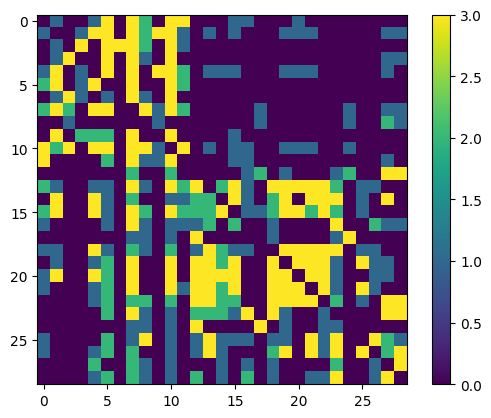

In [ ]:
plt.imshow(A.todense()); # here's what the adj mat looks like
plt.colorbar()

READ the description. What we are getting here are the weights of the layers, which do not mean what you think it means. You should pick a single layer, then convert through the adj matrix.

In [ ]:
Counter(g.ep.layer.a)

Counter({1: 361, 2: 181, 3: 198})

In [ ]:
g = gt.GraphView(g, efilt=g.ep.layer.a == 1)

The above filtering function is a bit opaque, but very neat once you get it.

In [ ]:
(g.ep.layer.a == 1)[:15] # this bit returns a numpy array, that you can easily vectorized.

PropertyArray([ True,  True,  True,  True,  True,  True,  True,  True,
                True,  True,  True,  True, False, False, False])

In [ ]:
A = gt.adjacency(g)
Gnx = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph) # be careful, we want a directed graph

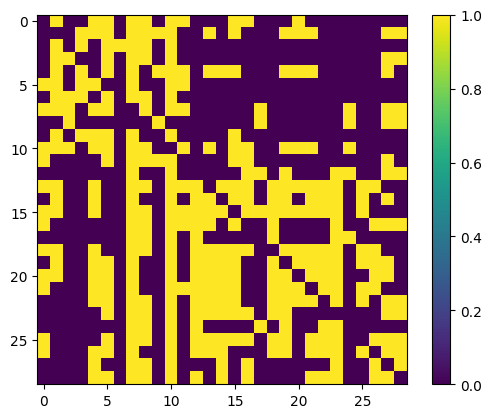

In [ ]:
plt.imshow(A.todense()); # here's what the adj mat looks like
plt.colorbar()

### Comparing networkx with graph-tools

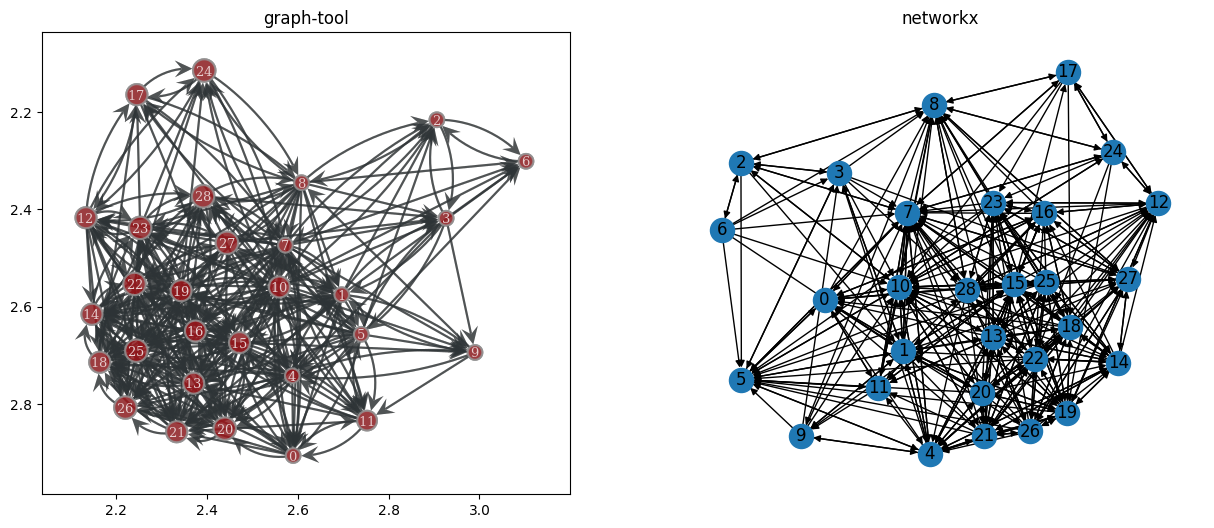

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

a = gt.graph_draw(g, pos=gt.fruchterman_reingold_layout(g), vertex_text=g.vertex_index, mplfig=ax[0])
a.fit_view(yflip=True)
ax[0].set_title("graph-tool")

nx.draw(Gnx, pos=nx.fruchterman_reingold_layout(Gnx), with_labels=True, ax=ax[1]);
ax[1].set_title("networkx");

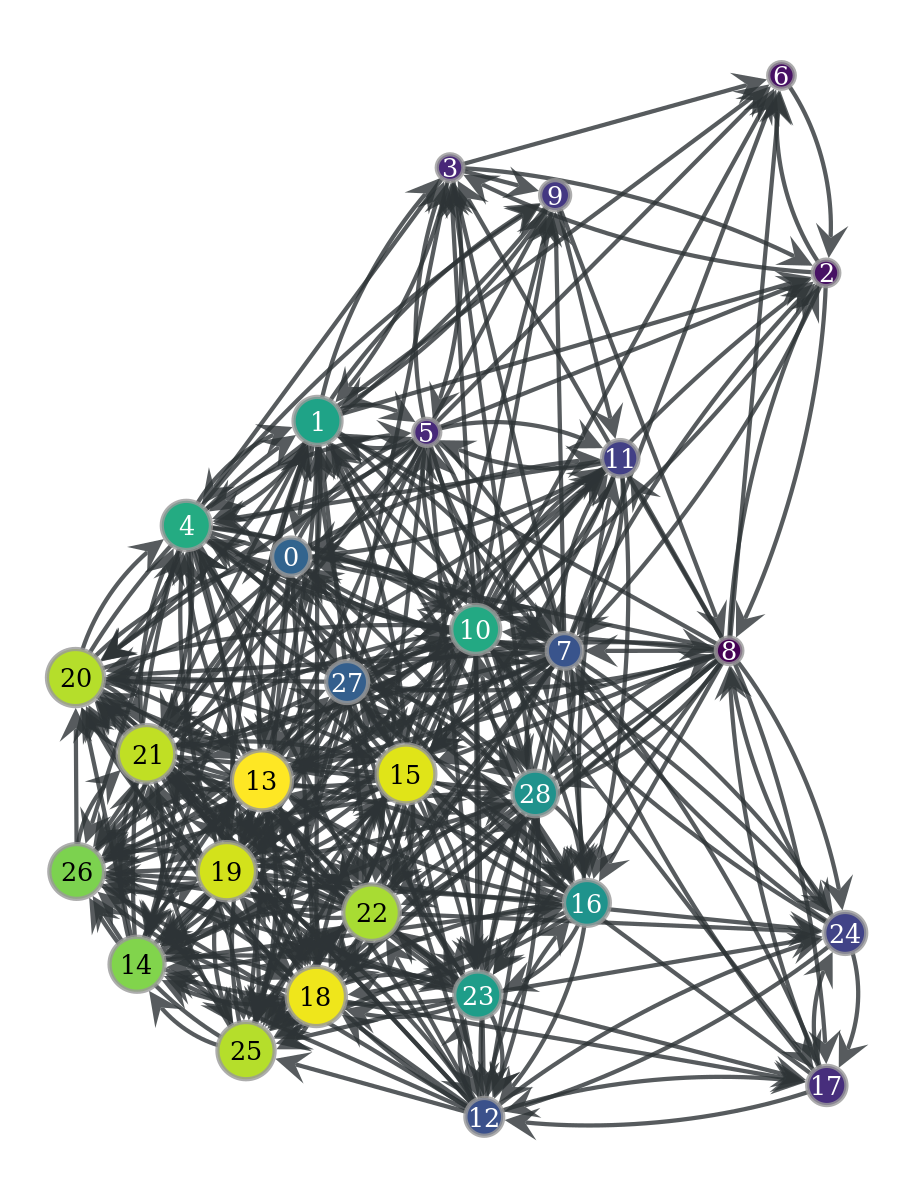

In [ ]:
ee, x = gt.eigenvector(g)

gt.graph_draw(
    g,
    pos=gt.fruchterman_reingold_layout(g),
    vertex_text=g.vertex_index,
    vertex_fill_color=x,
    vertex_size=gt.prop_to_size(x, mi=5, ma=30),
    vcmap=plt.cm.viridis
    );

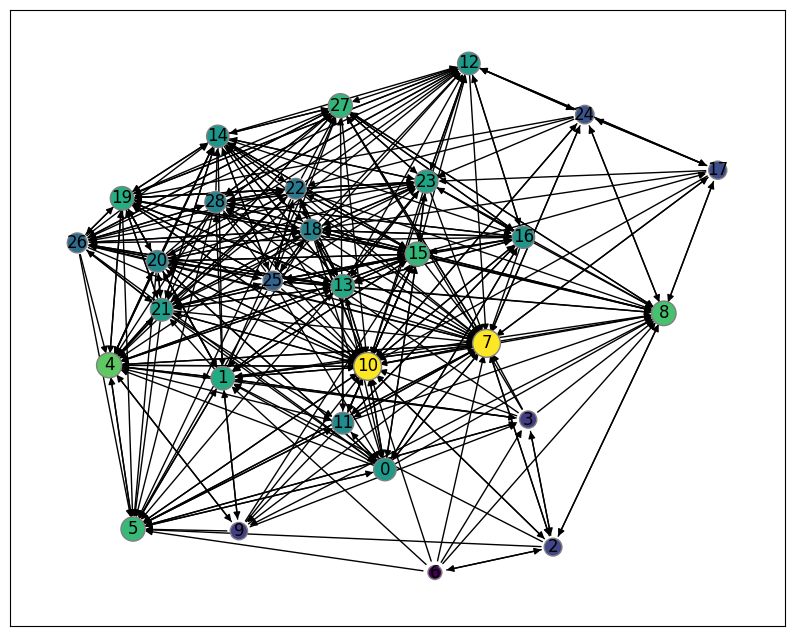

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
pos = nx.fruchterman_reingold_layout(Gnx)
eigen_vals = list(nx.eigenvector_centrality(Gnx).values())
node_attr = {
    "node_size": prop_to_size_custom(eigen_vals, 100, 400), # had to write a helper function
    'edgecolors': 'grey',
    "node_color": eigen_vals
  }
nx.draw_networkx_nodes(Gnx, pos=pos, ax=ax, cmap=plt.cm.viridis, **node_attr)
nx.draw_networkx_edges(Gnx, pos=pos, ax=ax)
nx.draw_networkx_labels(Gnx, pos=pos);

## `Graph-tools`community detection

> Graph-tools has the most sophisticated inference tools for community detection.

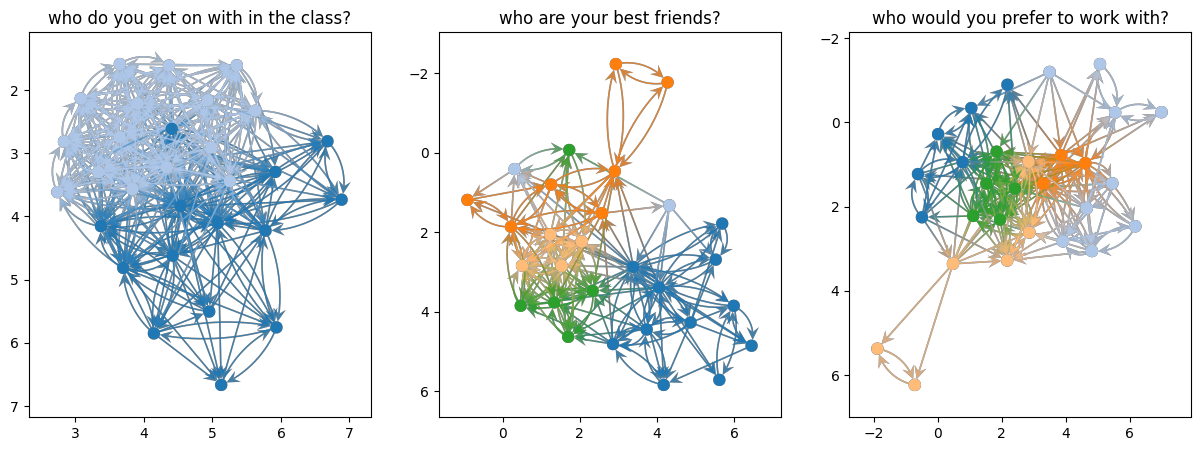

In [ ]:
g = gt.collection.ns["7th_graders"]
fig, ax = plt.subplots(1,3, figsize=(15,5))
titles = ["who do you get on with in the class?", "who are your best friends?", "who would you prefer to work with?"]
for i in range(3):
  u = gt.GraphView(g, efilt=g.ep.layer.a == (i+1))
  state = gt.minimize_blockmodel_dl(u)
  a = state.draw(mplfig=ax[i])
  a.fit_view(yflip=True)
  ax[i].set_title(titles[i])

## Large-size network: social media edition

Sometimes you'll see that you can download a particular graph with a specific subset, aka `g = gt.collection.ns["ego_social/facebook_combined"]`. To use the print function, do the following:

In [ ]:
print_summary("ego_social", "facebook_combined")

analyses
----------
average_degree: 43.69101262688784
degree_assortativity: 0.06357722918564919
degree_std_dev: 52.41411556737522
diameter: 8
edge_properties: []
edge_reciprocity: 1.0
global_clustering: 0.5191742775433075
hashimoto_radius: 161.28293197953244
is_bipartite: False
is_directed: False
knn_proj_1: 3.4769206504700274
knn_proj_2: 1.9360760589582005
largest_component_fraction: 1.0
mixing_time: 1194.9479652369826
num_edges: 88234
num_vertices: 4039
transition_gap: 0.9991634935432213
vertex_properties: [['_pos', 'vector<double>']]
bibtex
----------
['@misc{julian_discovering_2012,\n  doi          = {10.48550/ARXIV.1210.8182},\n  url          = {https://arxiv.org/abs/1210.8182},\n  author       = {McAuley, Julian and Leskovec, Jure},\n  keywords     = {Social and Information Networks (cs.SI), Physics and\n    Society (physics.soc-ph), FOS: Computer and information sciences,\n    FOS: Computer and information sciences, FOS: Physical sciences,\n    FOS: Physical sciences},\n  title 

In [ ]:
g = gt.collection.ns["ego_social/facebook_combined"]

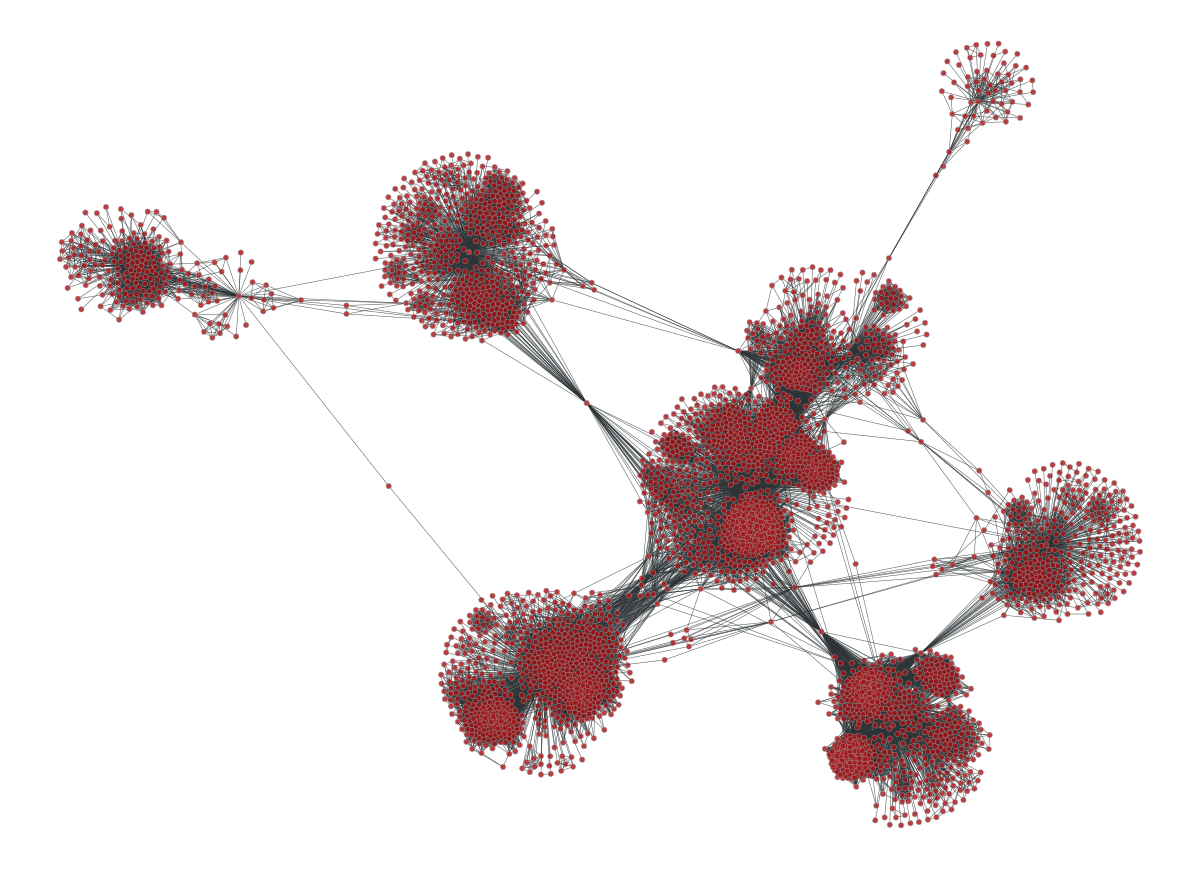

In [ ]:
gt.graph_draw(g, pos=g.vp._pos);

## Large-size network: advogato
I like to start by printing information about the network. Say that we are looking at the `advogato` network.

In [ ]:
print_summary("advogato")

analyses
----------
average_degree: 7.8163889313560615
degree_assortativity: -0.052796485761516326
degree_std_dev: 34.12941084115283
diameter: 9
edge_properties: [['weight', 'double']]
edge_reciprocity: 0.3851585268057973
global_clustering: 0.11104023204960285
hashimoto_radius: 68.60542306178223
is_bipartite: False
is_directed: True
knn_proj_1: 4.117164545800367
knn_proj_2: 2.5417987237312554
largest_component_fraction: 0.7708301482953677
mixing_time: 20.70975207197159
num_edges: 51127
num_vertices: 6541
transition_gap: 0.9528608197737135
vertex_properties: [['meta', 'string'], ['_pos', 'vector<double>']]


bibtex
----------
['@inproceedings{massa_bowling_2009,\n  doi          = {10.1109/dasc.2009.130},\n  url          = {https://doi.org/10.1109%2Fdasc.2009.130},\n  year         = 2009,\n  month        = dec,\n  publisher    = {{IEEE}},\n  author       = {Paolo Massa and Martino Salvetti and Danilo Tomasoni},\n  title        = {Bowling Alone and Trust Decline in Social Network\n    Sit

In [ ]:
g = gt.collection.ns["advogato"]

### Ridiculograms

Plotting for plotting sakes

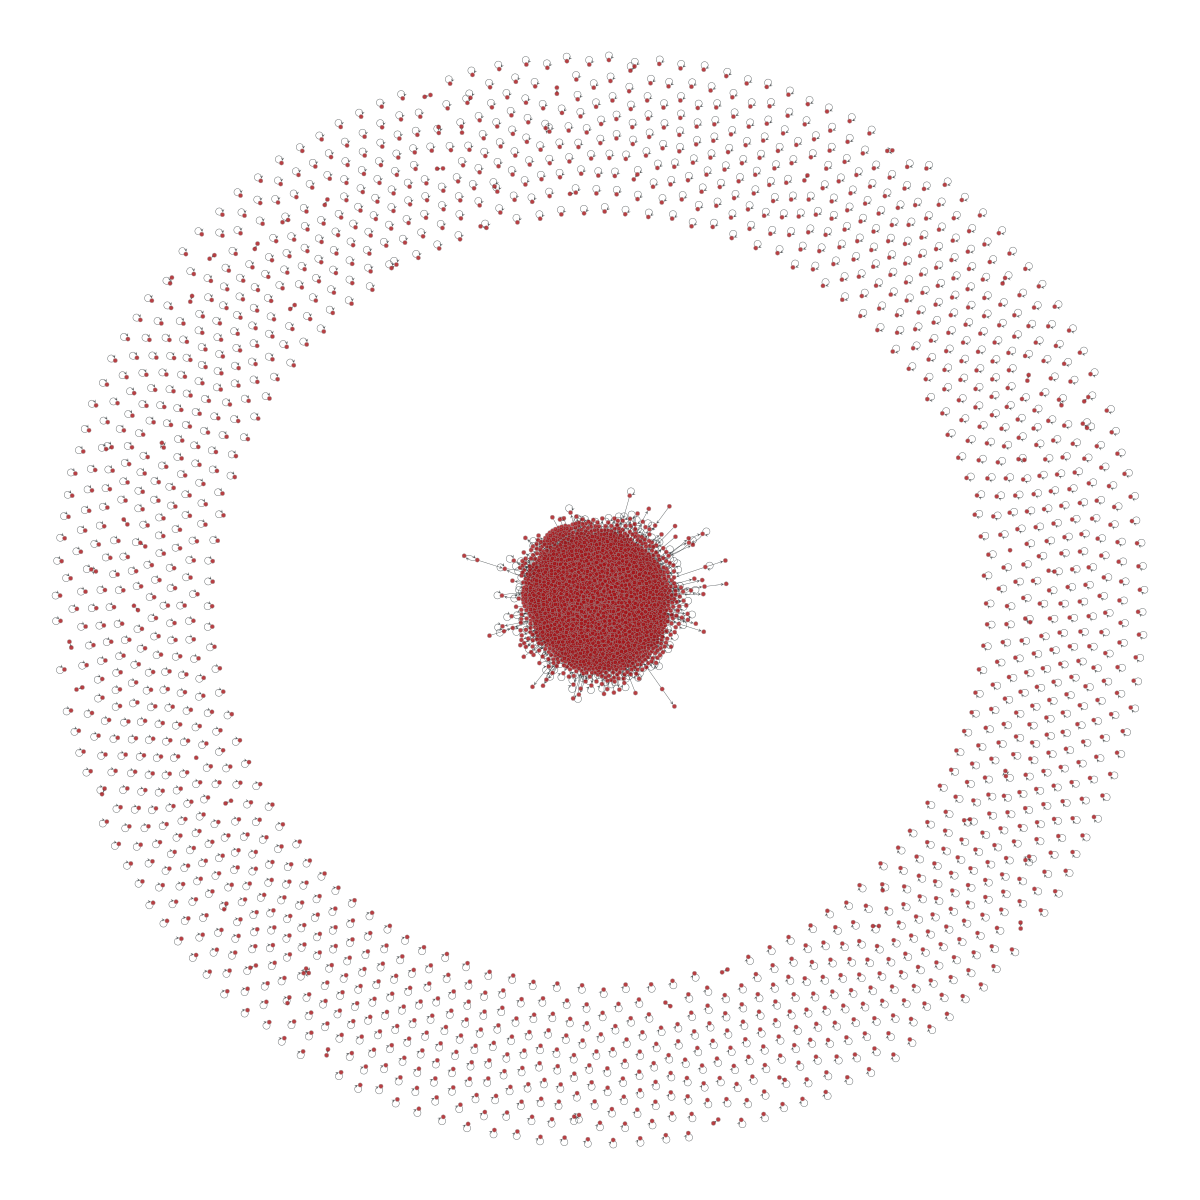

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7b14673efaf0, at 0x7b1465074d90>

In [ ]:
gt.graph_draw(g, pos=g.vp._pos); # nodes positionned according to metadata

A typical first move with large network is to examine the largest component:

In [ ]:
u = gt.extract_largest_component(g, prune=True) # https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.topology.extract_largest_component.html

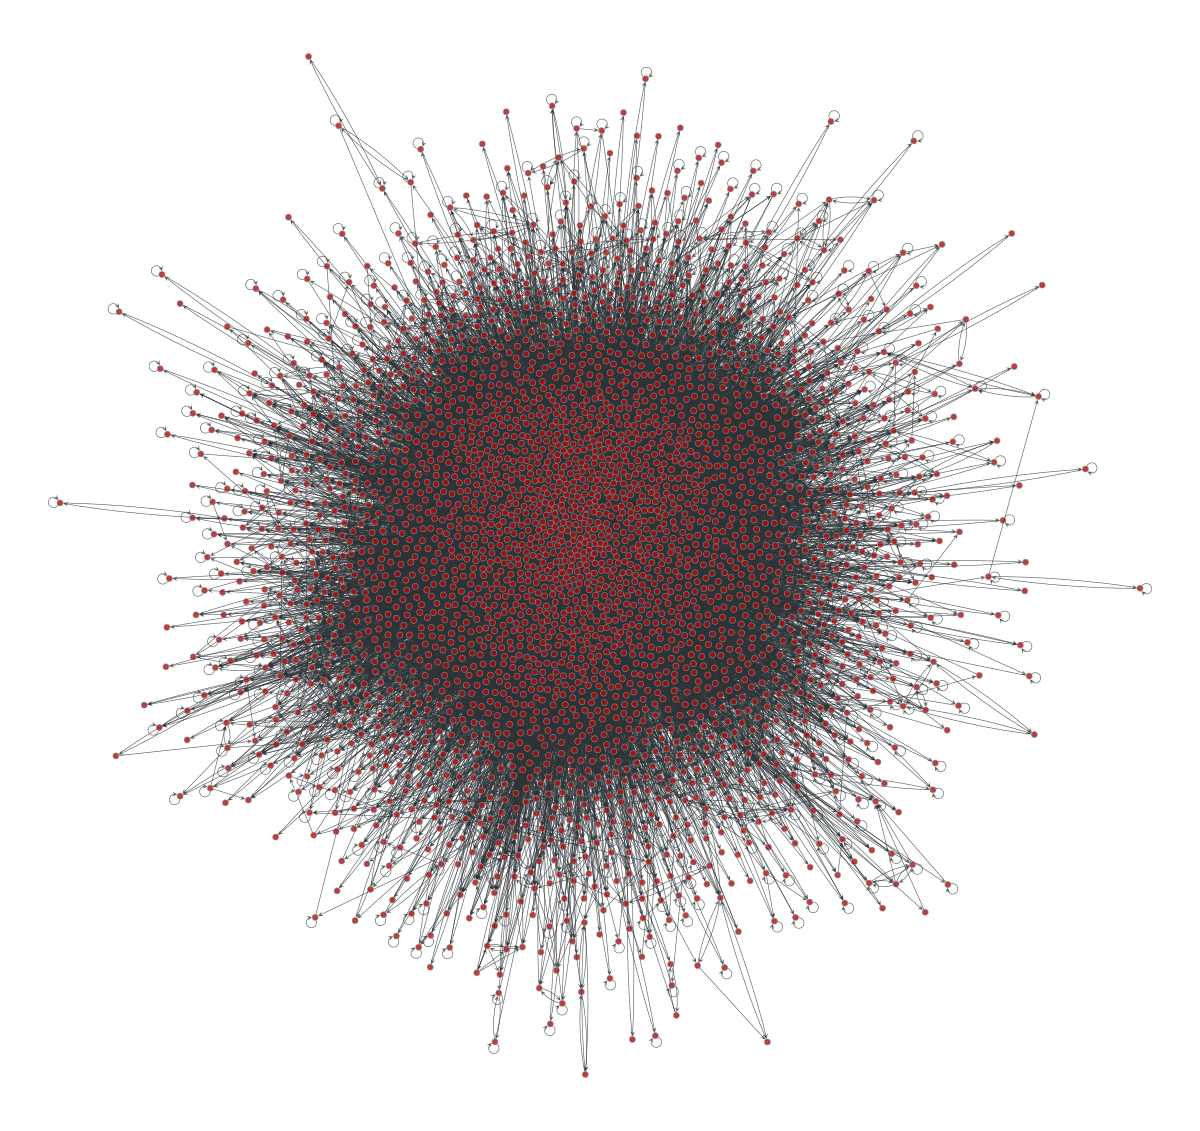

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7b14b6dea0e0, at 0x7b14b6de95a0>

In [ ]:
gt.graph_draw(u);

Still a hairball. This is typical. From the description above, we know this is a weighted, directed network. We could look at node importance in terms of in-degree centrality.

### Node proportional to betweenness

With `graph-tools`, I typically start from one example on the [quick start guide](https://graph-tool.skewed.de/static/doc/quickstart.html), then translate it into what i want. So we will start with betweenness centrality, which is also cool to visualize

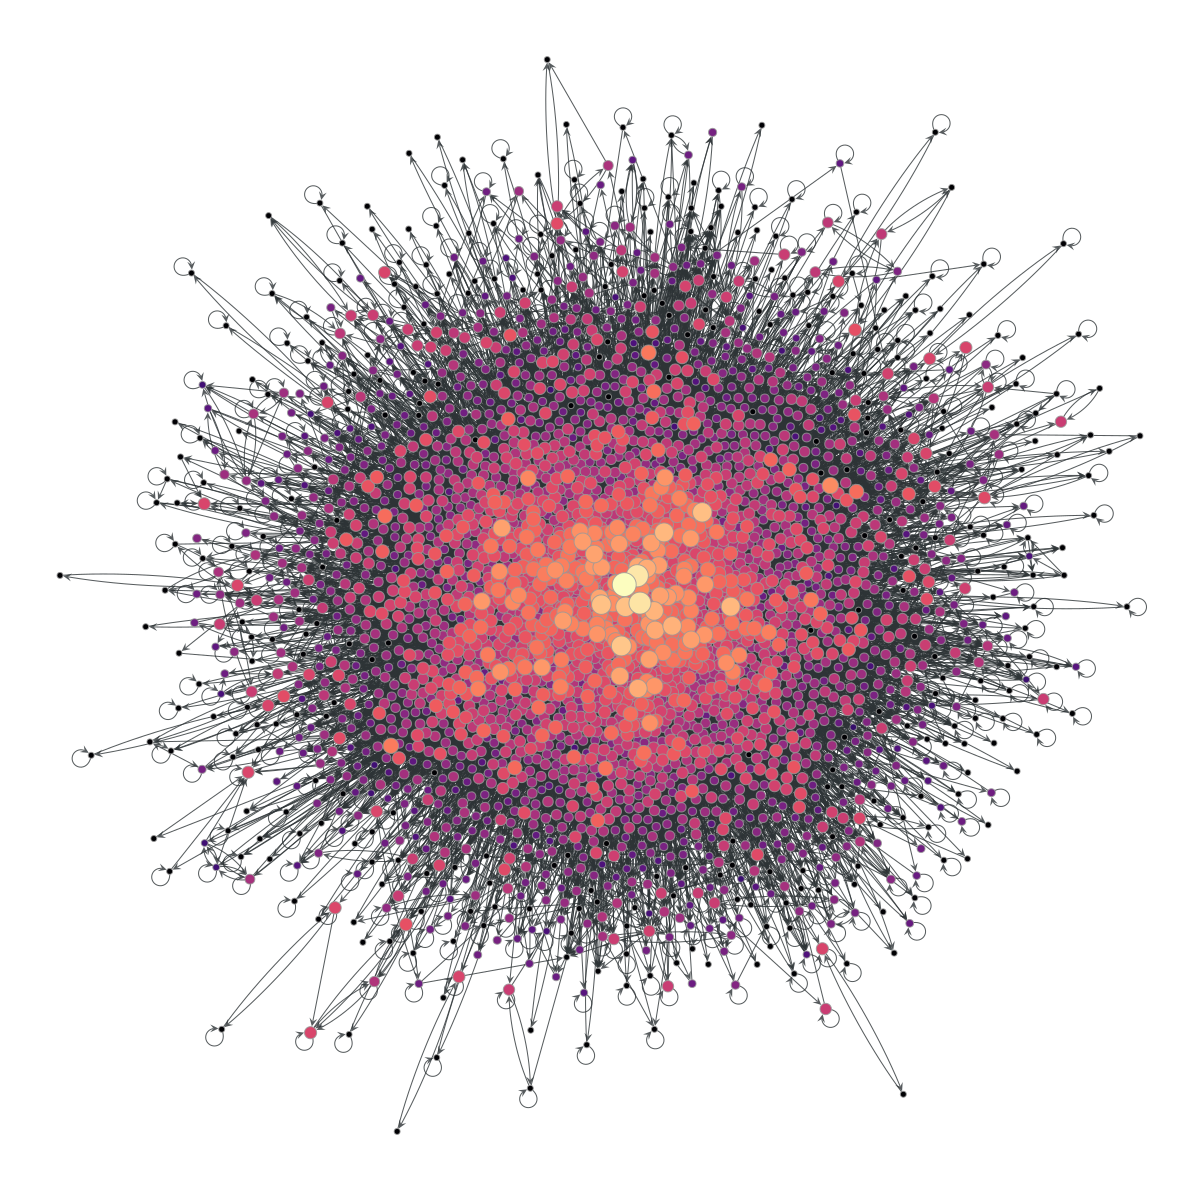

In [ ]:
vb, eb = gt.betweenness(u)
gt.graph_draw(u, pos = gt.sfdp_layout(u), vertex_fill_color=gt.prop_to_size(vb, 0, 1, power=.1),
              vertex_size=gt.prop_to_size(vb, 3, 12, power=.2), vorder=vb);

### kcore decomposition

> The k-core is a maximal set of vertices such that its induced subgraph only contains vertices with degree larger than or equal to k.

see [kcore_decomposition](https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.topology.kcore_decomposition.html)

In [ ]:
kcore = gt.kcore_decomposition(u)

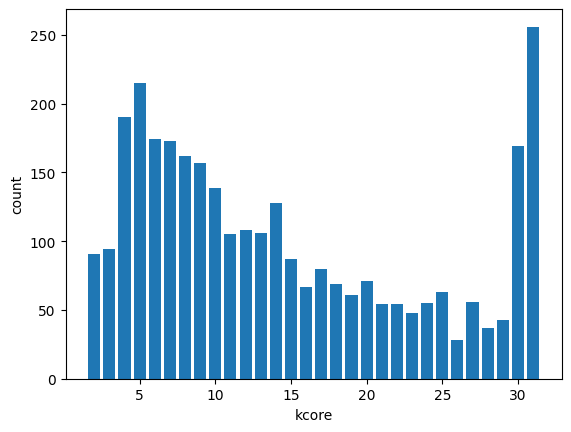

In [ ]:
count_kcore = Counter(kcore)
plt.bar(x=count_kcore.keys(), height=count_kcore.values())
plt.xlabel('kcore')
plt.ylabel('count');

In [ ]:
chosen_kcore = [(k > 3) and (k < 29) for k in kcore]

In [ ]:
uk = gt.GraphView(u, vfilt=chosen_kcore)

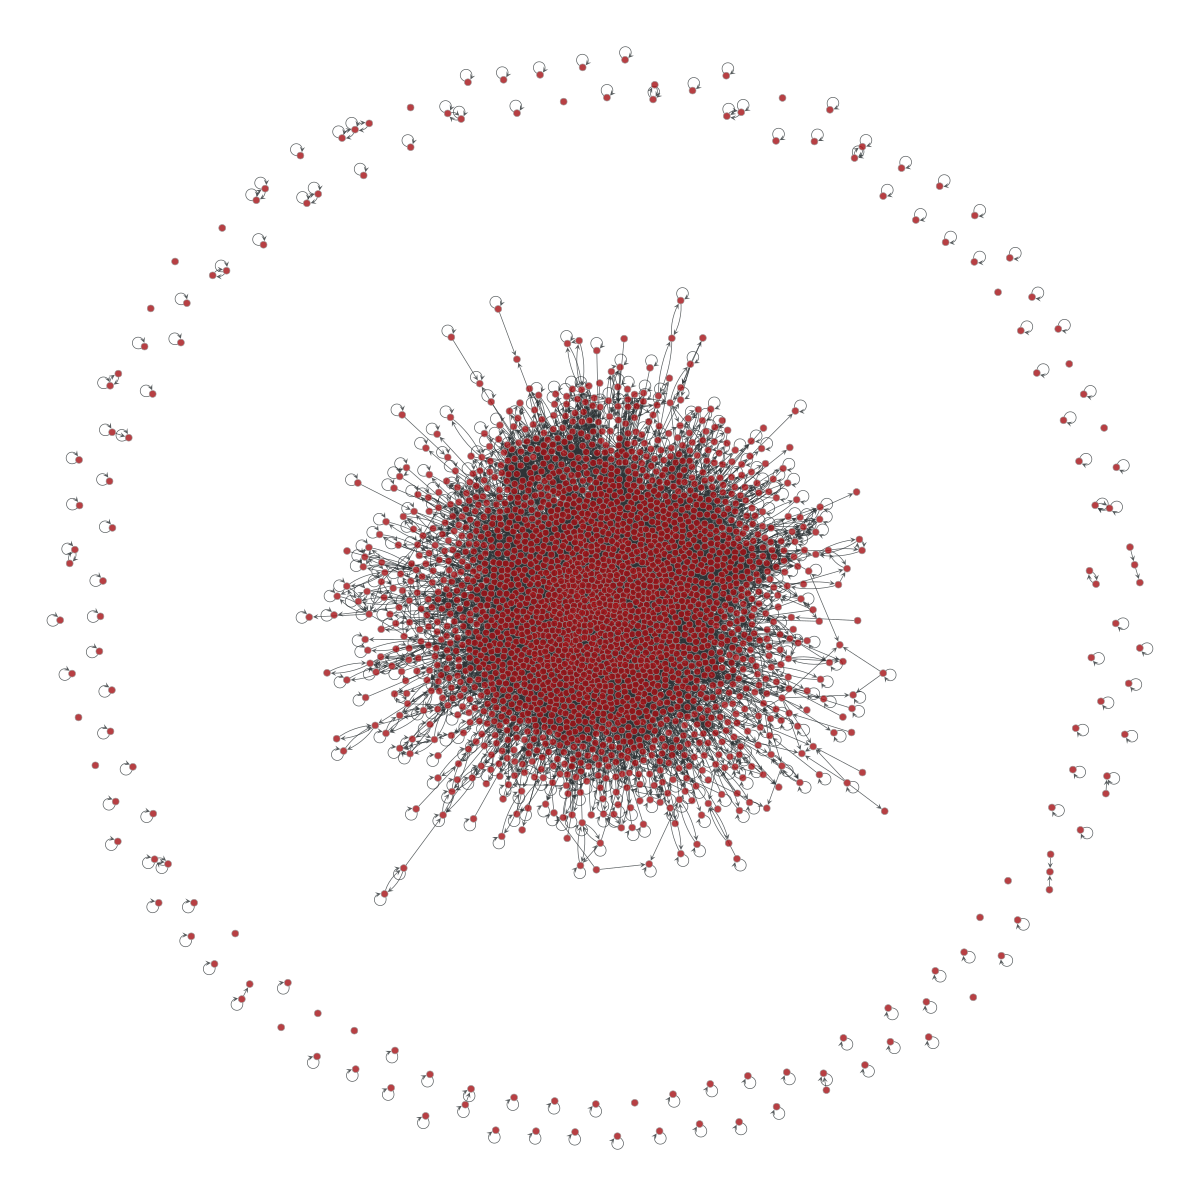

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7b1464f64520, at 0x7b1467269480>

In [ ]:
gt.graph_draw(
    uk,
    pos=gt.sfdp_layout(uk),
  )